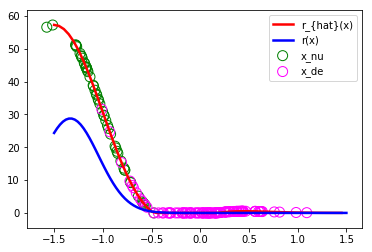

In [3]:
#!/usr/bin/python 

#THIS SOFTWARE IS DISTRIBUTED UNDER GPL LICENSE: 
#http://www.gnu.org/licenses/gpl.txt

from pylab import *
from scipy import linalg
from scipy.stats import norm

def compmedDist(X):
    size1=X.shape[0];
    Xmed = X;

    G = sum((Xmed*Xmed),1);
    Q = tile(G[:, newaxis],(1,size1));
    R = tile(G,(size1,1));

    dists = Q + R - 2*dot(Xmed,Xmed.T);
    dists = dists-tril(dists);
    dists= dists.reshape(size1**2,1,order='F').copy();
    return sqrt(0.5*median(dists[dists>0]));

def kernel_Gaussian(x, c, sigma):
    (d,nx) = x.shape
    (d,nc) = c.shape
    x2 = sum(x**2,0)
    c2 = sum(c**2, 0)

    distance2 = tile(c2,(nx,1)) + \
        tile(x2[:, newaxis],(1,nc)) \
        - 2* dot(x.T,c)
   
    return exp(-distance2/(2* (sigma**2)));

def R_ULSIF(x_nu, x_de, x_re, alpha, sigma_list,lambda_list, b, fold):
# x_nu: samples from numerator
# x_de: samples from denominator
# x_re: reference sample
# alpha: alpha defined in relative density ratio
# sigma_list, lambda_list: parameters for model selection
# b: number of kernel basis
# fold: number of fold for cross validation

    (d,n_nu) = x_nu.shape;
    (d,n_de) = x_de.shape;
    rand_index = permutation(n_nu);
    b = min(b,n_nu);
    #x_ce = x_nu[:,rand_index[0:b]]
    x_ce = x_nu[:,r_[0:b]]

    score_cv=zeros( (size(sigma_list), \
        size(lambda_list)));

    cv_index_nu = permutation(n_nu)
    #cv_index_nu = r_[0:n_nu]
    cv_split_nu=floor(r_[0:n_nu]*fold/n_nu)
    cv_index_de=permutation(n_de)
    #cv_index_de = r_[0:n_de]
    cv_split_de=floor(r_[0:n_de]*fold/n_de)

    for sigma_index in r_[0:size(sigma_list)]:
        sigma=sigma_list[sigma_index];
        K_de=kernel_Gaussian(x_de,x_ce,sigma).T;
        K_nu=kernel_Gaussian(x_nu,x_ce,sigma).T;

        score_tmp=zeros( (fold,size(lambda_list)));

        for k in r_[0:fold]:
            Ktmp1=K_de[:,cv_index_de[cv_split_de!=k]];
            Ktmp2=K_nu[:,cv_index_nu[cv_split_nu!=k]];
            
            Ktmp = alpha/Ktmp2.shape[1]*dot(Ktmp2,Ktmp2.T) + \
                (1-alpha)/Ktmp1.shape[1]*dot(Ktmp1, Ktmp1.T);
            
            mKtmp = mean(K_nu[:,cv_index_nu[cv_split_nu!=k]],1);
           
            for lambda_index in r_[0:size(lambda_list)]:
                
                lbd =lambda_list[lambda_index];
                
                thetat_cv= linalg.solve( Ktmp + lbd*eye(b), mKtmp);
                thetah_cv=thetat_cv;

                score_tmp[k,lambda_index]= alpha*mean(dot(K_nu[:,cv_index_nu[cv_split_nu==k]].T,thetah_cv)**2)/2. \
                    + (1-alpha)*mean(dot(K_de[:,cv_index_de[cv_split_de==k]].T, thetah_cv)**2)/2. \
                    - mean( dot(K_nu[:,cv_index_nu[cv_split_nu==k]].T, thetah_cv));

            score_cv[sigma_index,:]=mean(score_tmp,0);
    
    score_cv_tmp=score_cv.min(1);
    lambda_chosen_index = score_cv.argmin(1);

    score=score_cv_tmp.min();
    sigma_chosen_index = score_cv_tmp.argmin();

    lambda_chosen=lambda_list[lambda_chosen_index[sigma_chosen_index]];
    sigma_chosen=sigma_list[sigma_chosen_index];

    K_de=kernel_Gaussian(x_de,x_ce,sigma_chosen).T;
    K_nu=kernel_Gaussian(x_nu,x_ce,sigma_chosen).T;

    coe = alpha*dot(K_nu,K_nu.T)/n_nu + \
        (1-alpha)*dot(K_de,K_de.T)/n_de + \
        lambda_chosen*eye(b)
    var = mean(K_nu,1)
    
    thetat=linalg.solve(coe,var);
#    thetat=linalg.lstsq(coe,var)[0]
#    linalg.cho_factor(coe,overwrite_a=True)
#    linalg.cho_solve((coe,False), var, overwrite_b=True)
#    thetat = var
    
    #thetah=maximum(0,thetat)
    thetah = thetat;
    wh_x_de=dot(K_de.T,thetah).T;
    wh_x_nu=dot(K_nu.T,thetah).T;

    K_di=kernel_Gaussian(x_re,x_ce,sigma_chosen).T;
    wh_x_re=dot(K_di.T,thetah).T;

    wh_x_de[wh_x_de <0 ] = 0
    wh_x_re[wh_x_re <0] = 0;
    
    PE = mean(wh_x_nu) - 1./2*(alpha*mean(wh_x_nu**2) + \
        (1-alpha)*mean(wh_x_de**2)) - 1./2;

    return (PE,wh_x_re,score)

def sigma_list(x_nu,x_de):
    x = c_[x_nu, x_de];
    med = compmedDist(x.T);
    return med*array([0.6, 0.8, 1, 1.2, 1.4]);

def lambda_list():
    return 10.0**array([-3,-2,-1,0,1]);

def norm_pdf(x,mu,std):
    return exp(-(x-mu)**2/(2*(std**2)))/(std*sqrt(2*pi))

if __name__ == "__main__":
    seed(1)
    #generate data.        
    x_nu = randn(1,50)*.25- 1;
    x_de = randn(1,100)*.5;
    x_re = array([arange(-1.5,1.5,.05)])
    
    #using normal ULSIF, which is RULSIF with alpha = 0.
    alpha = 0;
    (PE,w,s) = R_ULSIF(x_nu, x_de, c_[x_re,x_nu,x_de], alpha, \
        sigma_list(x_nu,x_de),lambda_list(), x_nu.shape[1], 5)
    
    #plotting with true density ratio
    w_re = w[0:x_re.shape[1]]
    plot(x_re.T,w_re,label='r_{hat}(x)',linewidth=2.5, color='red')
    w_nu = w[x_re.shape[1]:x_re.shape[1]+x_nu.shape[1]]
    scatter(x_nu,w_nu,label='x_nu',color = 'green', facecolors='none' ,s=100)
    w_de= w[x_re.shape[1]+x_nu.shape[1]:]
    scatter(x_de,w_de,label='x_de',color='magenta', facecolors='none' ,s=100)
    
    x_disp = linspace(-1.5,1.5,100);
    plot(x_disp, norm_pdf(x_disp, -1,.25)/norm_pdf(x_disp, 0, .5),\
         linewidth = 2.5, label='r(x)',color='blue')
    legend()
    show()

    #print('alpha = ',alpha)
    #print('divergence = ', PE)
